使用之前5天的数据，对之后48小时的空气质量进行预测，模型如下

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-19-seq2seq_model.png)
<caption><center> **Figure 1**: lstm model</center></caption>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import seaborn as sns
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

from utils.plot_util import plot_forecast_and_actual_example
from metrics.metrics import SMAPE_on_dataset_v1
from seq2seq.seq2seq_data_util import get_training_statistics, generate_training_set, generate_dev_set
from seq2seq.multi_variable_seq2seq_model_parameters import build_graph

%load_ext autoreload
%autoreload 2

/home/cvdev/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

### 2. Args

多变量版本

In [3]:
station_list = ['dongsi_aq','tiantan_aq','guanyuan_aq','wanshouxigong_aq','aotizhongxin_aq',
            'nongzhanguan_aq','wanliu_aq','beibuxinqu_aq','zhiwuyuan_aq','fengtaihuayuan_aq',
            'yungang_aq','gucheng_aq','fangshan_aq','daxing_aq','yizhuang_aq','tongzhou_aq',
            'shunyi_aq','pingchang_aq','mentougou_aq','pinggu_aq','huairou_aq','miyun_aq',
            'yanqin_aq','dingling_aq','badaling_aq','miyunshuiku_aq','donggaocun_aq',
            'yongledian_aq','yufa_aq','liulihe_aq','qianmen_aq','yongdingmennei_aq',
            'xizhimenbei_aq','nansanhuan_aq','dongsihuan_aq']            
X_aq_list = ["PM2.5","PM10","O3","CO","SO2","NO2"]  
y_aq_list = ["PM2.5","PM10","O3"]
X_meo_list = ["temperature","pressure","humidity","direction","speed/kph"]
use_day=True
pre_days=5
batch_size=128

少变量版本（测试）

In [4]:
# station_list = ['aotizhongxin_aq']            
# X_aq_list = ["PM2.5","PM10","O3","CO","SO2","NO2"]  
# y_aq_list = ["PM2.5"]
# X_meo_list = ["temperature","pressure","humidity","direction","speed/kph"]
# use_day = True
# pre_days = 5
# batch_size = 128

### 3. Prepare test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [5]:
test_x, test_y = generate_dev_set(station_list=station_list,
                                  X_aq_list=X_aq_list, 
                                  y_aq_list=y_aq_list, 
                                  X_meo_list=None,
                                  pre_days=pre_days)

In [6]:
print(test_x.shape, test_y.shape)

(17, 120, 210) (17, 48, 105)


尝试生成一个训练样本，确保是我们想要的尺寸。

In [7]:
X_training_batch, y_training_batch = generate_training_set(station_list=station_list,
                                                           X_aq_list=X_aq_list,
                                                           y_aq_list=y_aq_list,
                                                           pre_days=pre_days,
                                                           X_meo_list=None,
                                                           use_day=True,
                                                           batch_size=batch_size)
print(X_training_batch.shape, y_training_batch.shape)

(128, 120, 210) (128, 48, 105)


### 4. Build the model and train the model 

In [8]:
input_seq_len = pre_days * 24
output_seq_len = 48
hidden_dim = 512
input_dim = 210
output_dim = 105
num_stacked_layers = 3

learning_rate=1e-3
lambda_l2_reg=0.003
GRADIENT_CLIPPING=2.5
total_iteractions = 2000
KEEP_RATE = 0.5

In [9]:
rnn_model = build_graph(feed_previous=False, 
                        input_seq_len=input_seq_len, 
                        output_seq_len=output_seq_len, 
                        hidden_dim=hidden_dim, 
                        input_dim=input_dim, 
                        output_dim=output_dim, 
                        num_stacked_layers=num_stacked_layers, 
                        learning_rate=learning_rate,
                        lambda_l2_reg=lambda_l2_reg,
                        GRADIENT_CLIPPING=GRADIENT_CLIPPING)

In [10]:
train_losses = []
val_losses = []

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    losses = []
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_training_set(station_list,
                                                          X_aq_list,
                                                          y_aq_list,
                                                          X_meo_list=None,
                                                          use_day=use_day,
                                                          pre_days=pre_days,
                                                          batch_size=batch_size)

        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t,:] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t,:] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict) 
        
        if i%10 == 0:
            print("loss after %d/%d iteractions : %.3f" %(i, total_iteractions, loss_t))
            
            # 想要对训练过程中训练集的 smape 进行监督，发现模型并不是处在“预测”的状态，因此放弃
            # train_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
            # train_preds = [np.expand_dims(pred, 1) for pred in train_preds]
            # train_preds = np.concatenate(train_preds, axis = 1)
            
        losses.append(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./seq2seq/new_multi_variable_model_results/', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)

Training losses: 
loss after 0/2000 iteractions : 151.999
loss after 10/2000 iteractions : 79.616
loss after 20/2000 iteractions : 74.756
loss after 30/2000 iteractions : 68.966
loss after 40/2000 iteractions : 65.922
loss after 50/2000 iteractions : 64.076
loss after 60/2000 iteractions : 62.529
loss after 70/2000 iteractions : 60.709
loss after 80/2000 iteractions : 59.410
loss after 90/2000 iteractions : 57.951
loss after 100/2000 iteractions : 56.729
loss after 110/2000 iteractions : 55.182
loss after 120/2000 iteractions : 53.705
loss after 130/2000 iteractions : 52.419
loss after 140/2000 iteractions : 50.912
loss after 150/2000 iteractions : 49.722
loss after 160/2000 iteractions : 47.996
loss after 170/2000 iteractions : 47.406
loss after 180/2000 iteractions : 46.253
loss after 190/2000 iteractions : 45.130
loss after 200/2000 iteractions : 44.166
loss after 210/2000 iteractions : 42.739
loss after 220/2000 iteractions : 41.732
loss after 230/2000 iteractions : 40.680
loss aft

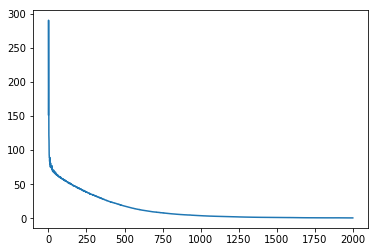

In [11]:
%matplotlib inline
plt.plot(losses)

## Inference on test 
Notice the batch prediction which is different to previous

In [12]:
rnn_model = build_graph(feed_previous=True, 
                        input_seq_len=input_seq_len, 
                        output_seq_len=output_seq_len, 
                        hidden_dim=hidden_dim, 
                        input_dim=input_dim, 
                        output_dim=output_dim, 
                        num_stacked_layers=num_stacked_layers, 
                        learning_rate=learning_rate,
                        lambda_l2_reg=lambda_l2_reg,
                        GRADIENT_CLIPPING=GRADIENT_CLIPPING)

In [13]:
init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./seq2seq/new_multi_variable_model_results/', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./seq2seq/new_multi_variable_model_results/multivariate_ts_pollution_case


In [14]:
print("Shape of predictions is ",final_preds.shape)

Shape of predictions is  (17, 48, 105)


### Example of many featutres

In [15]:
output_features = []
for station in station_list : 
    for aq_feature in y_aq_list :
        output_features.append(station + "_" + aq_feature)

# 特征要和训练时候的特征顺序保持一致
output_features.sort()

In [16]:
print(output_features)
print("Number of features is : ", len(output_features))

['aotizhongxin_aq_O3', 'aotizhongxin_aq_PM10', 'aotizhongxin_aq_PM2.5', 'badaling_aq_O3', 'badaling_aq_PM10', 'badaling_aq_PM2.5', 'beibuxinqu_aq_O3', 'beibuxinqu_aq_PM10', 'beibuxinqu_aq_PM2.5', 'daxing_aq_O3', 'daxing_aq_PM10', 'daxing_aq_PM2.5', 'dingling_aq_O3', 'dingling_aq_PM10', 'dingling_aq_PM2.5', 'donggaocun_aq_O3', 'donggaocun_aq_PM10', 'donggaocun_aq_PM2.5', 'dongsi_aq_O3', 'dongsi_aq_PM10', 'dongsi_aq_PM2.5', 'dongsihuan_aq_O3', 'dongsihuan_aq_PM10', 'dongsihuan_aq_PM2.5', 'fangshan_aq_O3', 'fangshan_aq_PM10', 'fangshan_aq_PM2.5', 'fengtaihuayuan_aq_O3', 'fengtaihuayuan_aq_PM10', 'fengtaihuayuan_aq_PM2.5', 'guanyuan_aq_O3', 'guanyuan_aq_PM10', 'guanyuan_aq_PM2.5', 'gucheng_aq_O3', 'gucheng_aq_PM10', 'gucheng_aq_PM2.5', 'huairou_aq_O3', 'huairou_aq_PM10', 'huairou_aq_PM2.5', 'liulihe_aq_O3', 'liulihe_aq_PM10', 'liulihe_aq_PM2.5', 'mentougou_aq_O3', 'mentougou_aq_PM10', 'mentougou_aq_PM2.5', 'miyun_aq_O3', 'miyun_aq_PM10', 'miyun_aq_PM2.5', 'miyunshuiku_aq_O3', 'miyunshuiku_

/home/cvdev/tf/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


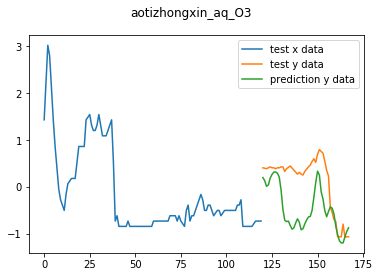

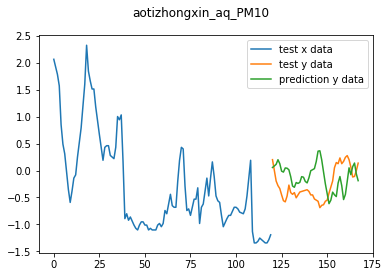

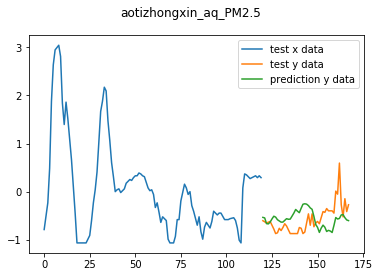

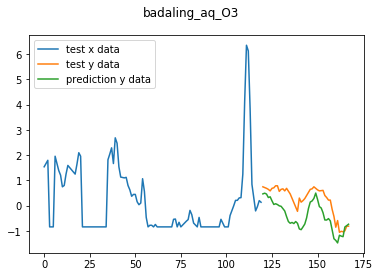

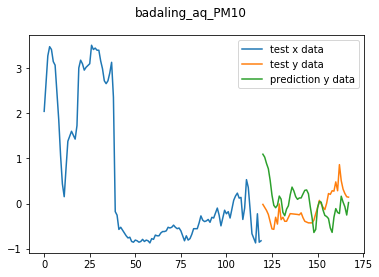

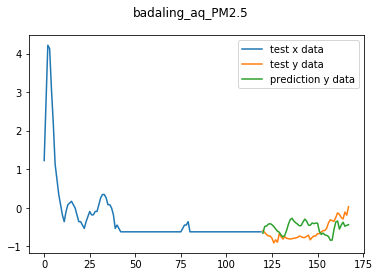

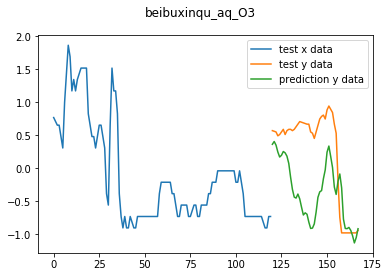

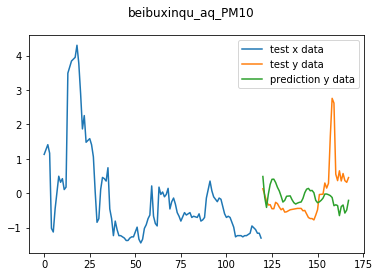

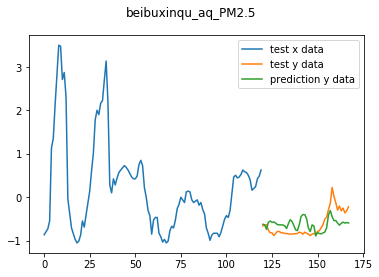

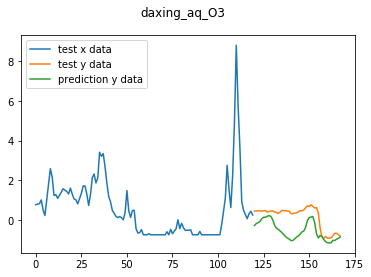

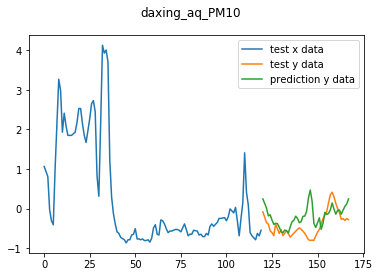

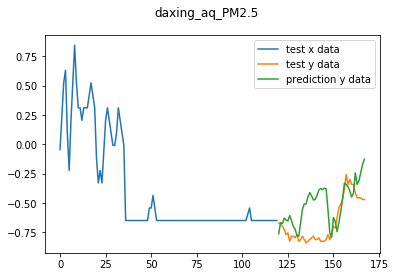

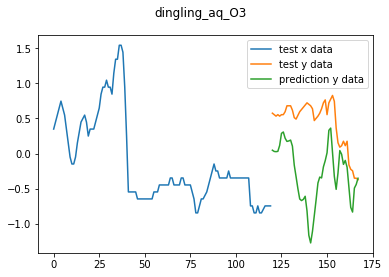

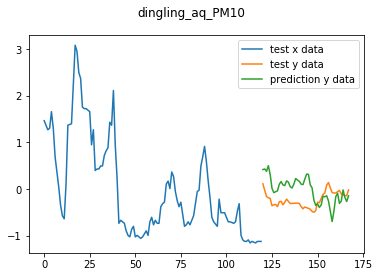

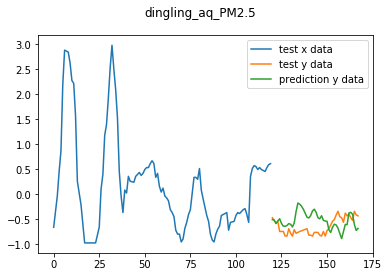

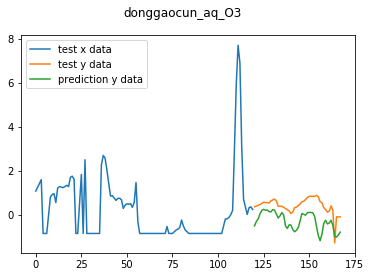

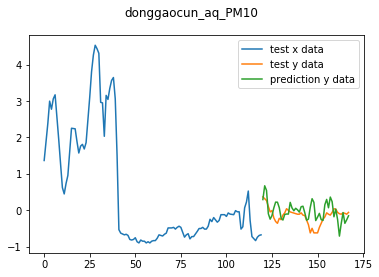

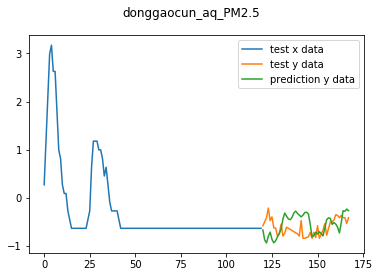

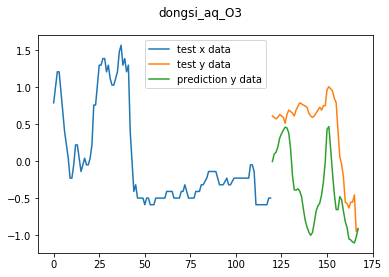

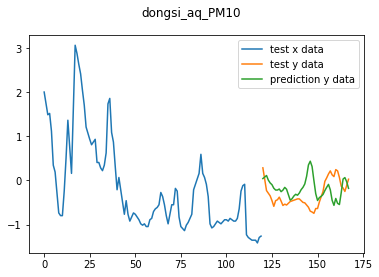

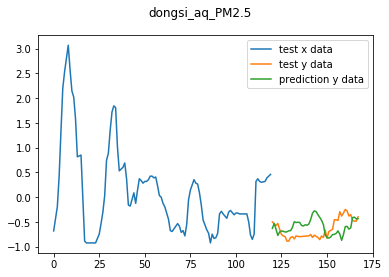

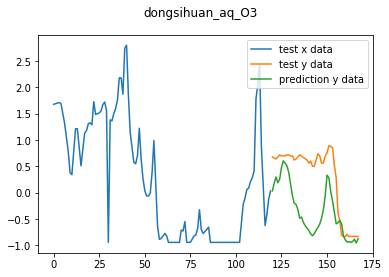

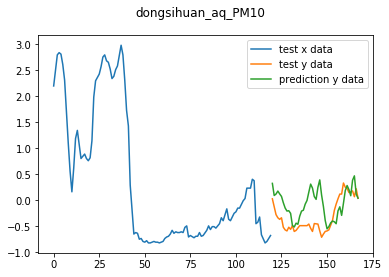

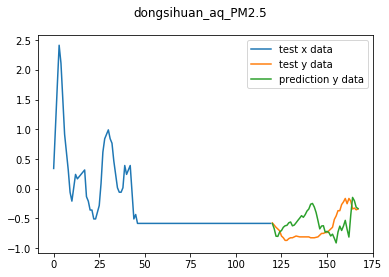

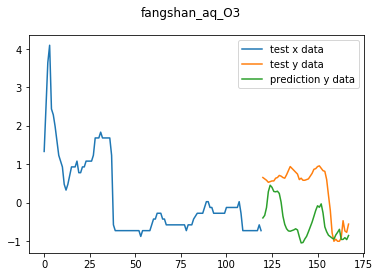

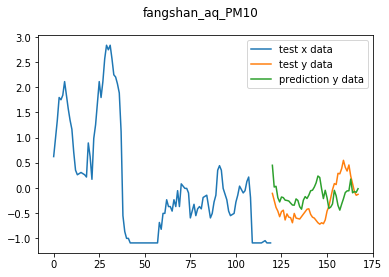

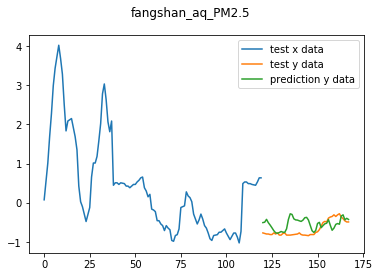

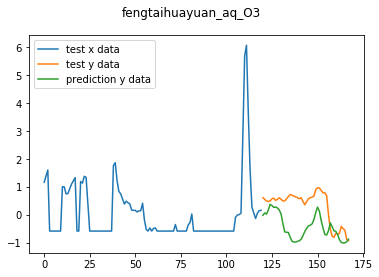

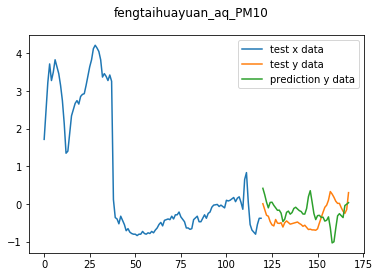

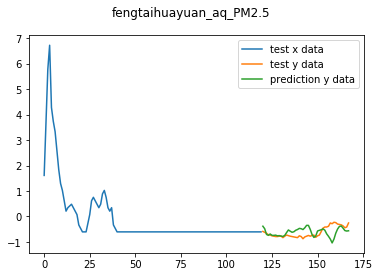

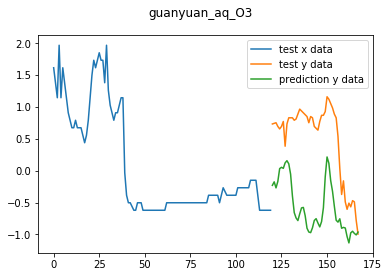

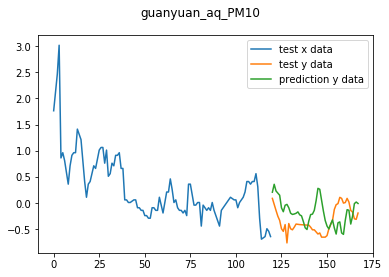

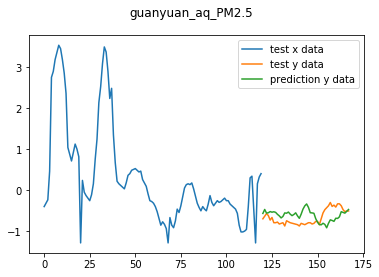

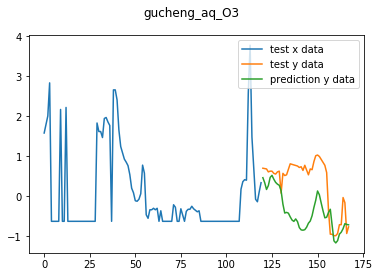

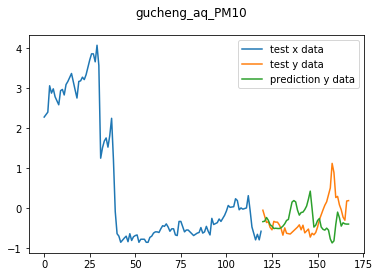

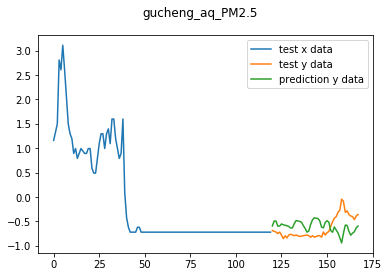

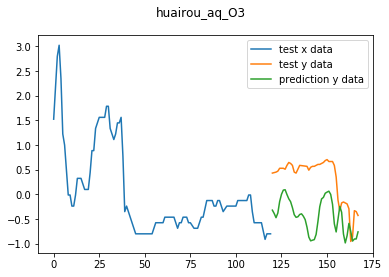

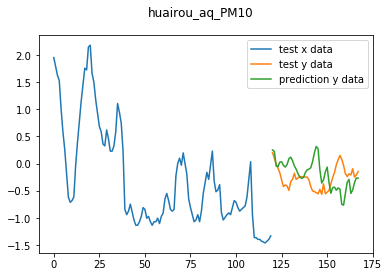

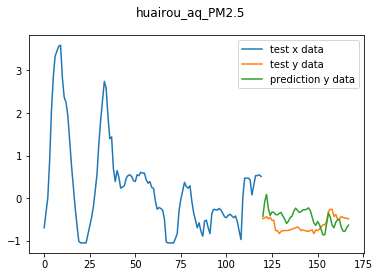

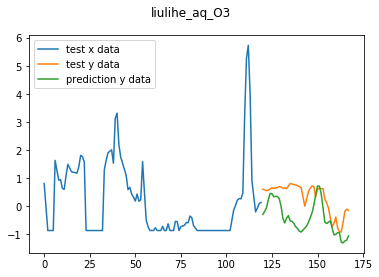

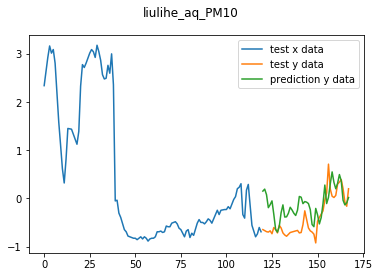

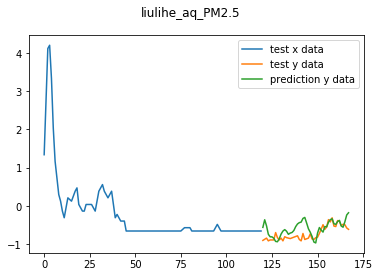

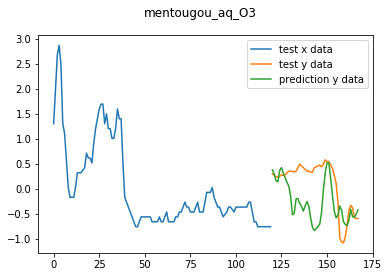

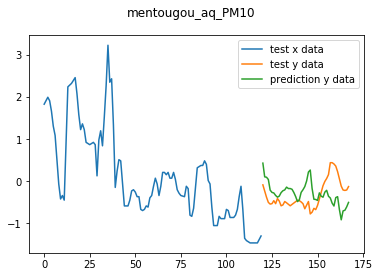

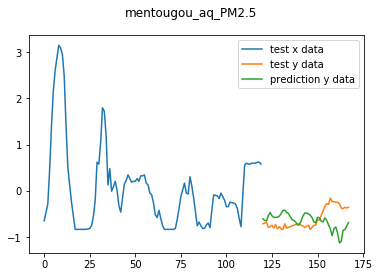

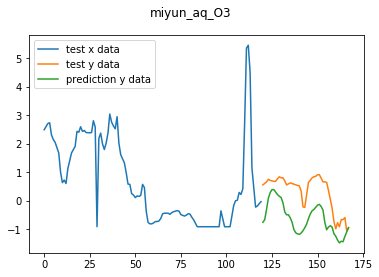

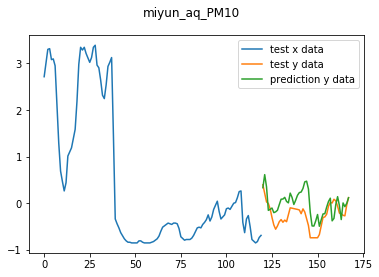

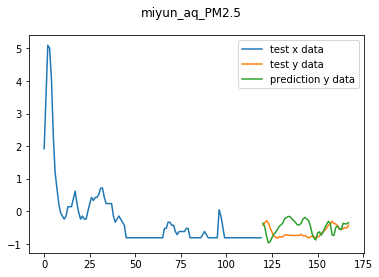

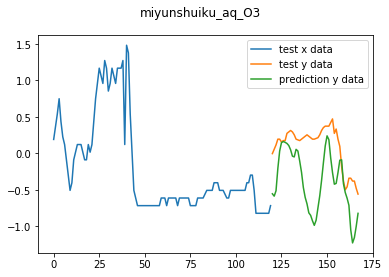

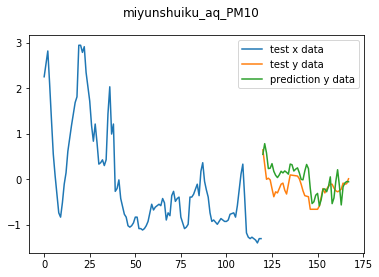

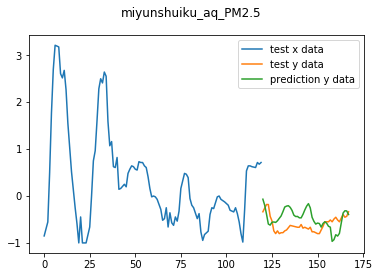

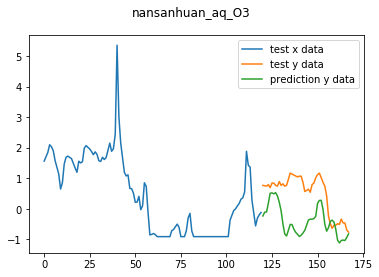

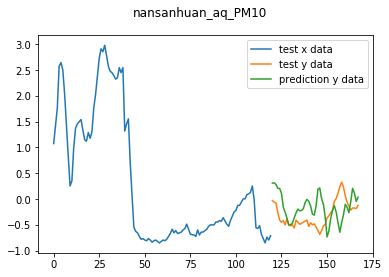

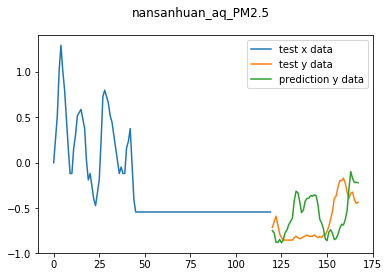

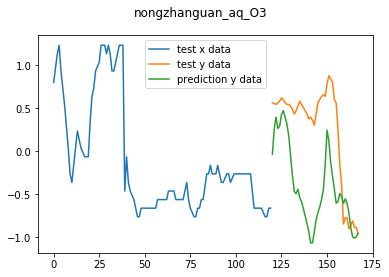

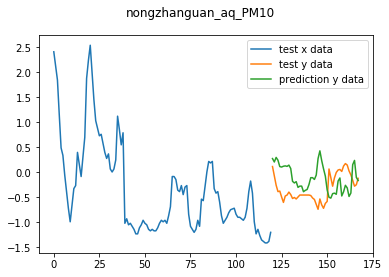

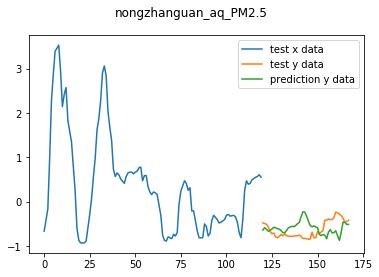

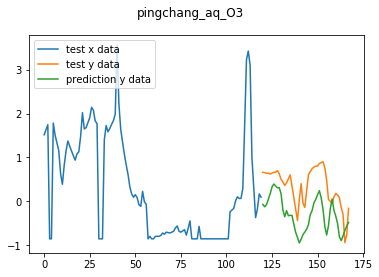

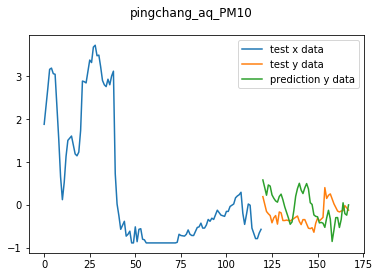

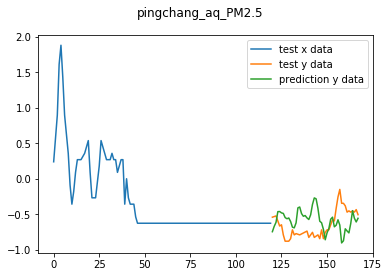

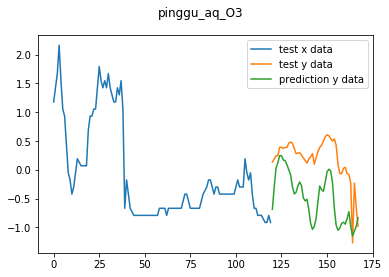

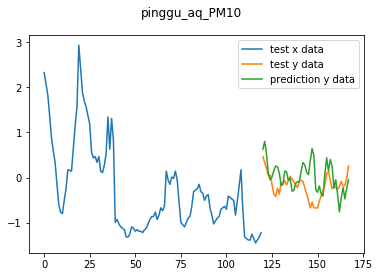

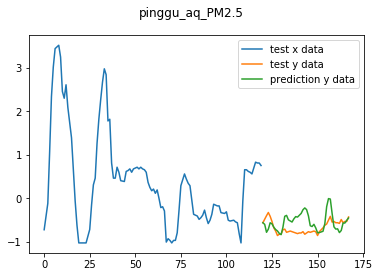

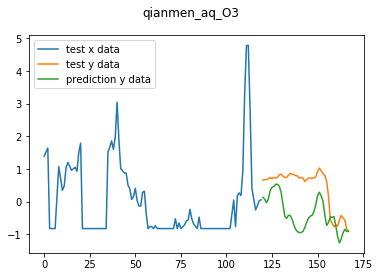

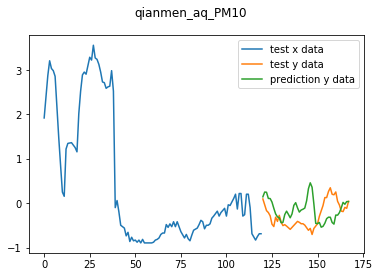

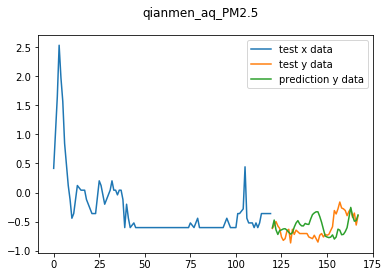

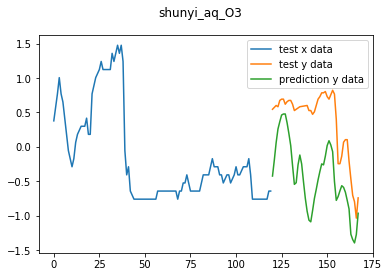

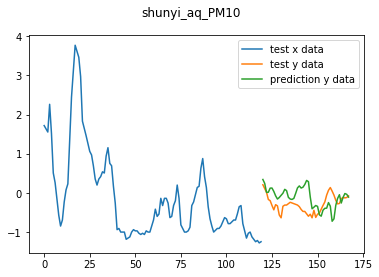

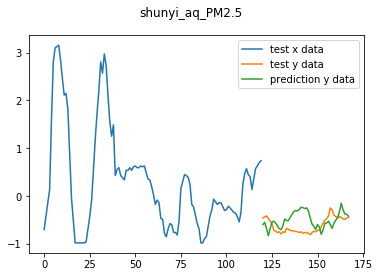

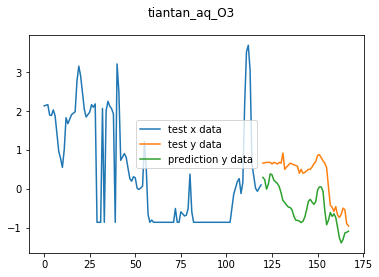

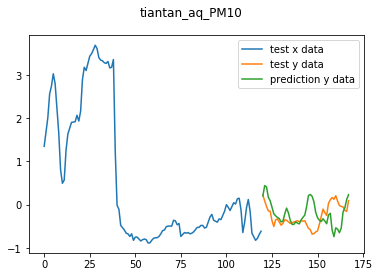

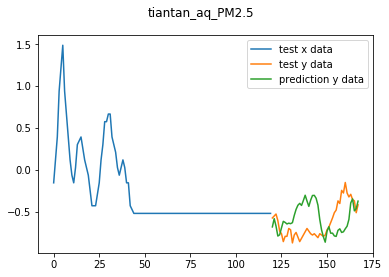

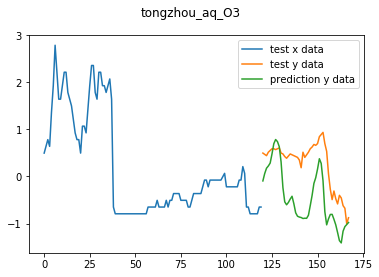

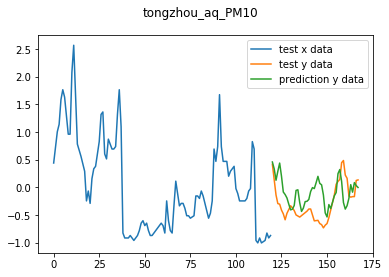

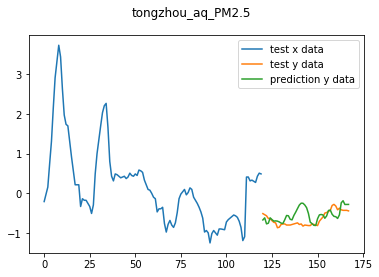

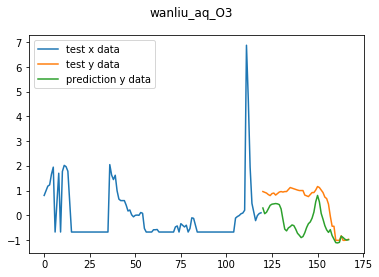

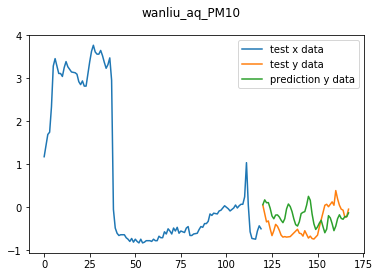

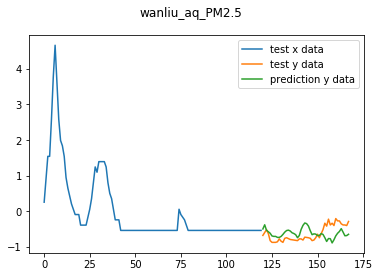

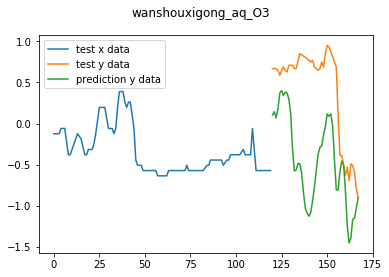

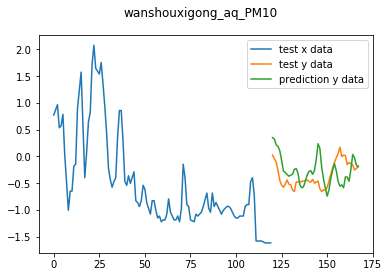

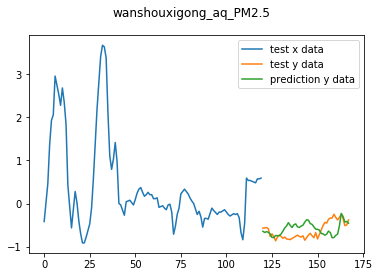

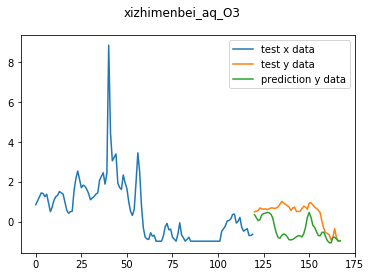

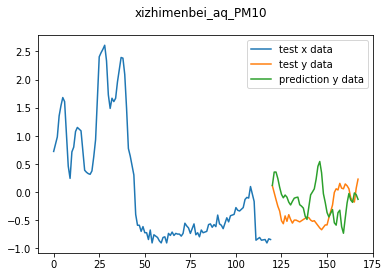

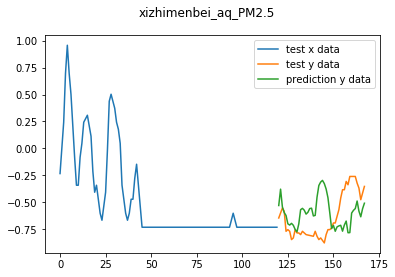

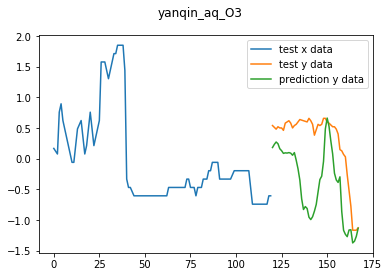

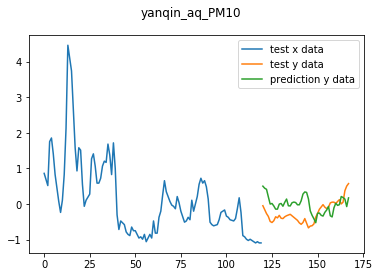

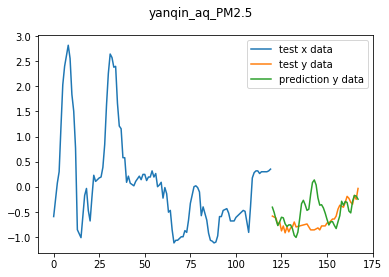

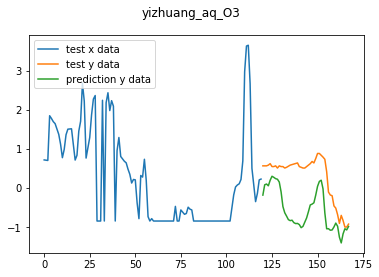

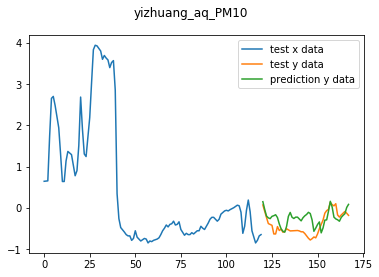

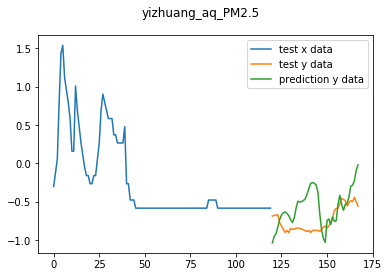

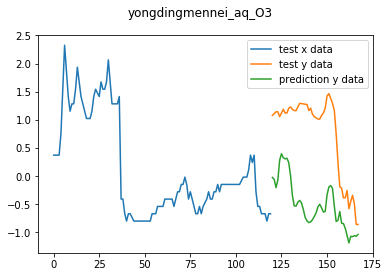

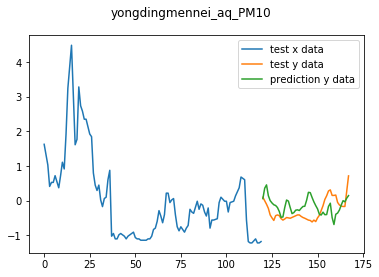

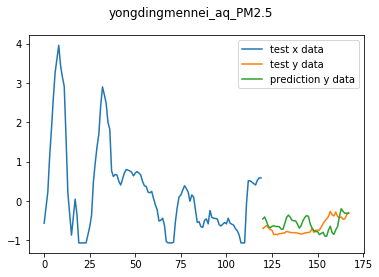

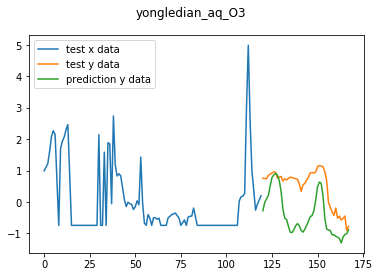

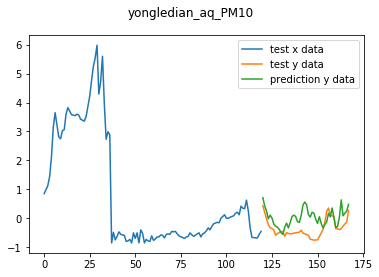

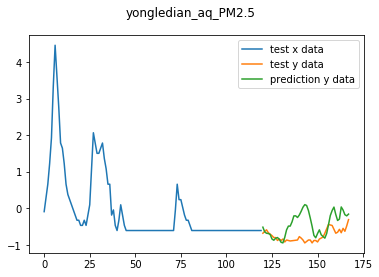

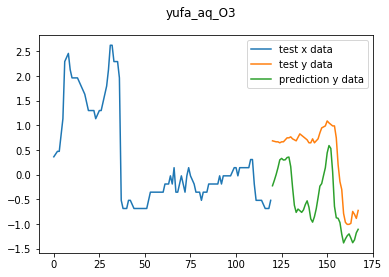

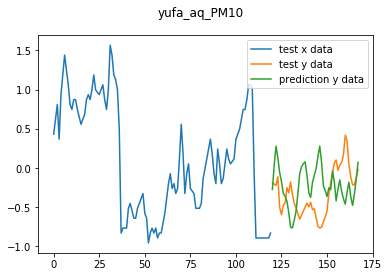

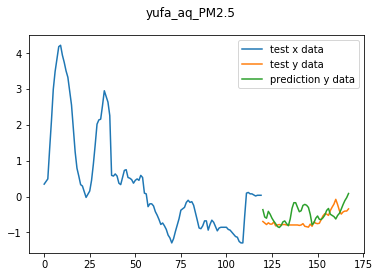

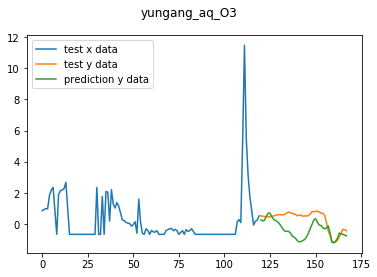

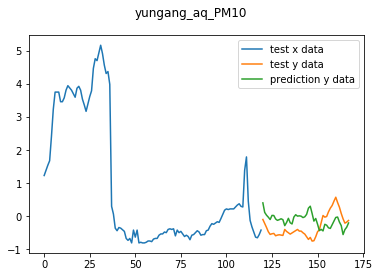

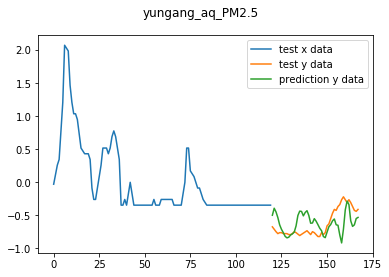

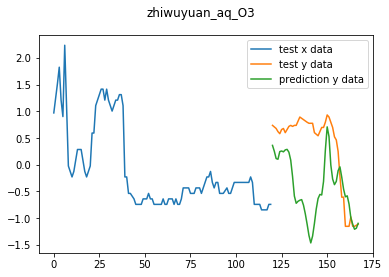

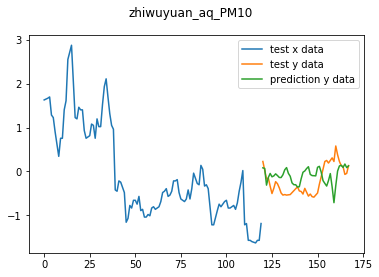

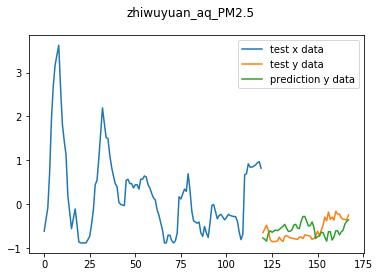

In [17]:
# 预测值普遍在 O3 上表现较好，另外两个参数　PM2.5 和　PM10 上通常捕捉不到高频分量
for i in range(len(output_features)):
    plot_forecast_and_actual_example(test_x, test_y, final_preds, output_features, index=0, feature_index=i)

### 某个特征在整个dev数据集时间跨度上的表现

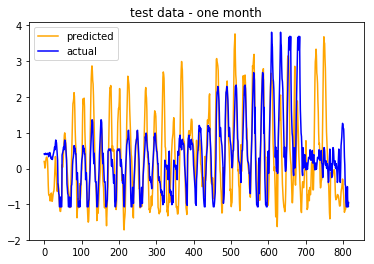

In [18]:
feature_index = 0
test_y_expand = np.concatenate([test_y[i,:,feature_index] for i in range(0, test_y.shape[0])], axis = 0)
final_preds_expand = np.concatenate([final_preds[i,:,feature_index] for i in range(0, final_preds.shape[0])], axis = 0)
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()

### Smapes of all features

载入训练样本的统计量

In [19]:
statistics = get_training_statistics()

In [20]:
statistics

,nongzhanguan_aq_PM2.5,nongzhanguan_aq_PM10,nongzhanguan_aq_NO2,nongzhanguan_aq_CO,nongzhanguan_aq_O3,nongzhanguan_aq_SO2,guanyuan_aq_PM2.5,guanyuan_aq_PM10,guanyuan_aq_NO2,guanyuan_aq_CO,...,yongledian_aq_temperature,yongledian_aq_pressure,yongledian_aq_humidity,yongledian_aq_wind_direction,yongledian_aq_wind_speed/kph,pinggu_aq_temperature,pinggu_aq_pressure,pinggu_aq_humidity,pinggu_aq_wind_direction,pinggu_aq_wind_speed/kph
label,,,,,,,,,,,,,,,,,,,,,
mean,60.270570,86.508707,49.520916,0.899456,54.615590,9.481894,59.297337,82.459596,50.657468,0.842730,...,11.554599,1016.679121,39.773854,197.015301,10.927671,10.591484,1001.588230,41.778629,193.124596,9.122660
std,65.838131,101.805670,31.605348,0.939021,53.782121,11.688182,62.905273,99.656668,30.790255,0.811781,...,11.763167,10.291141,21.658970,102.824005,6.459728,11.806261,9.558372,20.982975,111.122848,6.125807


计算 smape

In [21]:
aver_smapes, smapes_of_features = SMAPE_on_dataset_v1(test_y, final_preds, output_features, statistics, 1)

In [22]:
# smape value on all features
smapes_of_features

{'aotizhongxin_aq_O3': 0.7569750512494344,
 'aotizhongxin_aq_PM10': 0.7361136110206675,
 'aotizhongxin_aq_PM2.5': 0.7516679913661032,
 'badaling_aq_O3': 0.7515694866781822,
 'badaling_aq_PM10': 0.7953559708537926,
 'badaling_aq_PM2.5': 0.8027077861701741,
 'beibuxinqu_aq_O3': 0.893737624010767,
 'beibuxinqu_aq_PM10': 0.8115567555427017,
 'beibuxinqu_aq_PM2.5': 0.7926900792159013,
 'daxing_aq_O3': 0.7784586830062993,
 'daxing_aq_PM10': 0.6920113727299165,
 'daxing_aq_PM2.5': 0.7440581513477125,
 'dingling_aq_O3': 0.4627963947307392,
 'dingling_aq_PM10': 0.8699445974896657,
 'dingling_aq_PM2.5': 0.8275241896230372,
 'donggaocun_aq_O3': 0.46283712915393177,
 'donggaocun_aq_PM10': 0.9475834611102888,
 'donggaocun_aq_PM2.5': 0.7968548092382715,
 'dongsi_aq_O3': 0.6800167314848666,
 'dongsi_aq_PM10': 0.7083919845494401,
 'dongsi_aq_PM2.5': 0.7415294850587353,
 'dongsihuan_aq_O3': 0.8785600453217095,
 'dongsihuan_aq_PM10': 0.7015734553706932,
 'dongsihuan_aq_PM2.5': 0.7338026890610183,
 'fang

In [23]:
print("The average smape on all features in the dev set is : ",aver_smapes)

The average smape on all features in the dev set is :  0.7474923615694444


- epoch - aver_smape relationship
    - 50 0.85
    - 1000 0.75

# ChangeLog
- 0427 v0
    - 完成了第一版本模型